# To do list
- get the config and .pt files from s3 instead of from wandb (or local)
- refactor a lot of this code
- make the visualizations in 3d a little better (add tooltips for belief states)
- add visualizations of the actual data generating process and MSP!

In [1]:
from epsilon_transformers.persistence import S3Persister
from epsilon_transformers.training.configs.model_configs import RawModelConfig

persister = S3Persister(collection_location="rrxor")
filenames = persister.list_objects()

# get all filenames with .pt in them, these are the savepoints
filenames_pt = [x for x in filenames if ".pt" in x]
filenames_other = [x for x in filenames if ".pt" not in x]
print(len(filenames_pt))
# sort them by the number in the filename
filenames_pt.sort(key=lambda x: int(x.split("_")[-1].split(".")[0]))
print(filenames_pt[-10:])
print(filenames_other)


AttributeError: 'S3Persister' object has no attribute 'list_objects'

In [25]:
persister.load_model(object_name=filenames_pt[-1], device='cpu')


HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0-3): 4 x TransformerBlock(
      (ln1): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (hook_resi

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import wandb
from epsilon_transformers.analysis.wandb import fetch_artifacts_for_run
from epsilon_transformers.analysis.wandb import fetch_run_config
from epsilon_transformers.analysis.wandb import load_model_artifact
from epsilon_transformers.analysis.wandb import download_artifacts

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

user_or_org = "adamimos"
project_name = "transformer-MSPs"
run_id = "vfs4q106"  # rrxor 

wandb.init(id=run_id, resume='must')
arts = fetch_artifacts_for_run(user_or_org, project_name, run_id)
print(f"Found {len(arts)} artifacts")


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Using device: cpu


wandb: Currently logged in as: adamimos. Use `wandb login --relogin` to force relogin


Found 31788 artifacts


In [2]:

download_dir = "./downloaded_artifacts"  # Specify your directory here
download_artifacts(arts, download_dir)

config = fetch_run_config(user_or_org, project_name, run_id)


Found 31787 existing .pt files in ./downloaded_artifacts


In [3]:
import os
# get the number in each filename in the download_dir
# and make it a list of ints, then sort it and see if any are missing
filenames = [int(x.split("_")[-1].split(".")[0]) for x in os.listdir(download_dir)]
filenames.sort()
print(f"Missing: {set(range(filenames[0], filenames[-1])) - set(filenames)}")


Missing: {31783, 31784, 31785, 31786, 31787, 31788, 31789, 31790, 31791, 31792, 31795, 31796, 31797, 31798, 31799, 31800, 31801, 31802, 31803, 31804, 31805, 31806, 31807, 31808, 31809, 31811, 31812, 31813, 31814, 31815, 31816, 31817, 31818, 31819, 31820, 31821, 31822, 31823, 31824, 31825, 31826, 31827, 31828, 31829, 31830, 31831, 31832, 31833, 31834}


In [11]:
from epsilon_transformers.process.processes import RRXOR
import numpy as np
from epsilon_transformers.training.configs.model_configs import RawModelConfig

model = model_config = RawModelConfig(
            d_vocab=config["d_vocab"],
            d_model=config["d_model"],
            n_ctx=config["n_ctx"],
            d_head=config["d_head"],
            n_head=config["n_heads"],
            d_mlp=config["d_model"] * 4,
            n_layers=config["n_layers"],
        ).to_hooked_transformer(seed=1337, device=device)


save_point = 20000
model.load_state_dict(torch.load(f"{download_dir}/model_epoch_{save_point}.pt", map_location=device))

process = RRXOR()


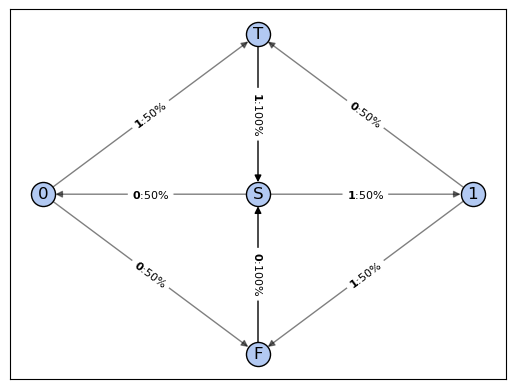

In [12]:
from epsilon_transformers.visualization.graph import transition_matrix_to_graph, visualize_graph
graph = transition_matrix_to_graph(transition_matrix=process.transition_matrix,state_names=process.state_names_dict)
visualize_graph(graph, draw_mixed_state=True, layout='spectral')

In [13]:
msp = process.derive_mixed_state_presentation(depth=config["n_ctx"] + 1)
msp_paths_and_beliefs = msp.paths_and_belief_states

msp_paths = [np.array(x[0]) for x in msp_paths_and_beliefs]
msp_beliefs = [x[1] for x in msp_paths_and_beliefs]
msp_beliefs = [tuple(round(b, 5) for b in belief) for belief in msp_beliefs]
msp_unique_beliefs = set(msp_beliefs)
print(f"Unique beliefs: {len(msp_unique_beliefs)} out of {len(msp_beliefs)}")

msp_belief_index = {b: i for i, b in enumerate(msp_unique_beliefs)}
msp_beliefs_index = [msp_belief_index[tuple(round(b, 5) for b in belief)] for belief in msp_unique_beliefs]

X = [x for x in msp.paths if len(x) == config["n_ctx"]]
X = torch.tensor(X, dtype=torch.int).to(device)  # (batch, n_ctx)

X_beliefs = torch.zeros(X.shape[0], X.shape[1], 5).to(device)
X_belief_indices = torch.zeros(X.shape[0], X.shape[1], 1, dtype=torch.int).to(device)  # Specify dtype

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        p = X[i, :j+1].cpu().numpy()
        path_index = np.where([np.array_equal(p, x) for x in msp_paths])[0][0]  # Get the first index
        msp_belief_state = msp_beliefs[path_index]
        X_beliefs[i, j] = torch.tensor(msp_belief_state, dtype=torch.float32)
        X_belief_indices[i, j] = msp_belief_index[msp_belief_state]  # Assign directly


Unique beliefs: 36 out of 1723


In [14]:
MSP_transition = msp.build_transition_graph()


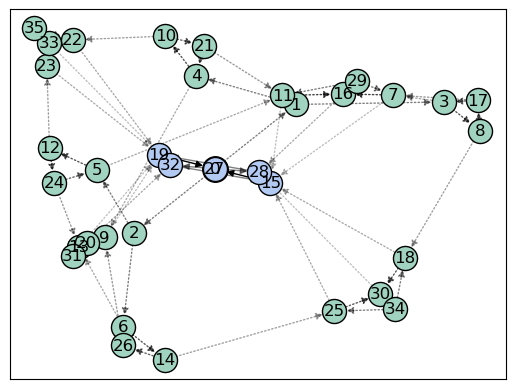

In [15]:
# make a process out of the transition matrix
from epsilon_transformers.process.processes import TransitionMatrixProcess
process = TransitionMatrixProcess(transition_matrix=MSP_transition)
graph = transition_matrix_to_graph(transition_matrix=MSP_transition)
visualize_graph(graph, draw_mixed_state=True, layout='spectral', draw_edge_labels=False)


In [5]:
def summarize_paths_and_beliefs(msp):
    """
    Summarizes the paths and beliefs from a mixed state presentation (msp).

    This function takes a mixed state presentation object, extracts the paths and belief states,
    and prints the total number of paths and beliefs. It then rounds the belief states to 5 decimal
    points and identifies unique beliefs, aggregating paths that lead to the same rounded belief state.
    Additionally, it returns two dictionaries: one mapping unique rounded belief states (as tuples) to lists of paths that lead to them,
    and another mapping individual paths (as strings) to their beliefs.

    Parameters:
    - msp (MixedStatePresentation): The mixed state presentation object containing paths and belief states.

    Returns:
    - tuple of dicts: A tuple containing two dictionaries. The first dictionary maps unique rounded belief states (as tuples) to lists of paths that lead to them.
                      The second dictionary maps individual paths (as strings) to their beliefs.
    """

    paths_and_beliefs = msp.paths_and_belief_states
    paths = [x[0] for x in paths_and_beliefs]
    beliefs = [x[1] for x in paths_and_beliefs]
    print(f"Paths: {len(paths)}, Beliefs: {len(beliefs)}")

    unique_beliefs_with_paths = {}
    path_to_belief = {}

    for path, belief in zip(paths, beliefs):
        rounded_belief = tuple(round(b, 5) for b in belief)
        path_str = ''.join([str(x) for x in path])
        path_to_belief[path_str] = rounded_belief  # Map path string to belief

        if rounded_belief not in unique_beliefs_with_paths:
            unique_beliefs_with_paths[rounded_belief] = [path_str]
        else:
            unique_beliefs_with_paths[rounded_belief].append(path_str)

    print(f"Unique beliefs with rounding to 5 decimal points: {len(unique_beliefs_with_paths)}")
    # for belief, paths in unique_beliefs_with_paths.items():
    #    print(f"Belief: {belief}, Paths: {len(paths)}")

    return unique_beliefs_with_paths, path_to_belief

msp_belief_paths_dict, msp_path_to_belief_dict = summarize_paths_and_beliefs(msp)

# now let's index each belief

msp_index_to_belief = {i: k for i, k in enumerate(msp_belief_paths_dict.keys())}
msp_belief_to_index = {k: i for i, k in enumerate(msp_belief_paths_dict.keys())}


_, cache = model.run_with_cache(X, names_filter=lambda x: 'ln1.hook_normalized' in x)

acts = torch.cat([cache[f"blocks.{i}.ln1.hook_normalized"] for i in range(4)], dim=-1) # (batch, n_ctx, 4 * d_model)



Paths: 1723, Beliefs: 1723
Unique beliefs with rounding to 5 decimal points: 36


In [6]:
from epsilon_transformers.process.processes import RRXOR
import numpy as np
from epsilon_transformers.training.configs import RawModelConfig
import torch
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

model_config = RawModelConfig(
    d_vocab=config["d_vocab"],
    d_model=config["d_model"],
    n_ctx=config["n_ctx"],
    d_head=config["d_head"],
    n_head=config["n_heads"],
    d_mlp=config["d_model"] * 4,
    n_layers=config["n_layers"],
).to_hooked_transformer(seed=1337, device=device)

save_point = 0
model.load_state_dict(torch.load(f"{download_dir}/model_epoch_{save_point}.pt", map_location=device))

process = RRXOR()
msp = process.derive_mixed_state_presentation(depth=config["n_ctx"] + 1)
msp_paths_and_beliefs = msp.paths_and_belief_states

msp_paths = [np.array(x[0]) for x in msp_paths_and_beliefs]
msp_beliefs = [x[1] for x in msp_paths_and_beliefs]
msp_beliefs = [tuple(round(b, 5) for b in belief) for belief in msp_beliefs]
msp_unique_beliefs = list(set(msp_beliefs))  # Convert to list for indexing
print(f"Unique beliefs: {len(msp_unique_beliefs)} out of {len(msp_beliefs)}")


pca = PCA(n_components=3)
pca.fit(msp_unique_beliefs)
msp_beliefs_pca = pca.transform(msp_unique_beliefs)

msp_belief_index = {b: i for i, b in enumerate(msp_unique_beliefs)}
msp_beliefs_index = [msp_belief_index[tuple(round(b, 5) for b in belief)] for belief in msp_unique_beliefs]

X = [x for x in msp.paths if len(x) == config["n_ctx"]]
X = torch.tensor(X, dtype=torch.int).to(device)  # (batch, n_ctx)

X_beliefs = torch.zeros(X.shape[0], X.shape[1], 5).to(device)
X_belief_indices = torch.zeros(X.shape[0], X.shape[1], 1, dtype=torch.int).to(device)  # Specify dtype

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        p = X[i, :j+1].cpu().numpy()
        path_index = np.where([np.array_equal(p, x) for x in msp_paths])[0][0]  # Get the first index
        msp_belief_state = msp_beliefs[path_index]
        X_beliefs[i, j] = torch.tensor(msp_belief_state, dtype=torch.float32)
        X_belief_indices[i, j] = msp_belief_index[msp_belief_state]  # Assign directly

_, cache = model.run_with_cache(X, names_filter=lambda x: 'ln1.hook_normalized' in x)

acts = torch.cat([cache[f"blocks.{i}.ln1.hook_normalized"] for i in range(4)], dim=-1)  # (batch, n_ctx, 4 * d_model)

acts_flattened = acts.view(-1, acts.shape[-1]).cpu().numpy()
X_beliefs_flattened = X_beliefs.view(-1, X_beliefs.shape[-1]).cpu().numpy()

regression = LinearRegression()
regression.fit(acts_flattened, X_beliefs_flattened)

result = regression.predict(acts_flattened)

result_pca = pca.transform(result)

X_belief_indices_flattened = X_belief_indices.view(-1).cpu().numpy()

colors = px.colors.qualitative.Light24 + px.colors.qualitative.Dark24 + px.colors.qualitative.Plotly

fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]])

msp_beliefs_pca_data = msp_beliefs_pca
for b in range(len(msp_unique_beliefs)):
    relevant_indices = [i for i, x in enumerate(msp_beliefs_index) if x == b]  # Use list comprehension
    relevant_data = msp_beliefs_pca_data[relevant_indices]
    fig.add_trace(go.Scatter3d(x=relevant_data[:, 0],
                               y=relevant_data[:, 1],
                               z=relevant_data[:, 2],
                               mode='markers',
                               name=f'Belief {b}',
                               marker=dict(size=5, color=colors[b], opacity=1.0)),
                  row=1, col=1)

for b in range(len(msp_unique_beliefs)):
    relevant_indices = np.where(X_belief_indices_flattened == b)[0]
    relevant_data = result_pca[relevant_indices]
    centers_of_mass = np.mean(relevant_data, axis=0)
    fig.add_trace(go.Scatter3d(x=[centers_of_mass[0]],
                               y=[centers_of_mass[1]],
                               z=[centers_of_mass[2]],
                               mode='markers',
                               name=f'Belief {b}',
                               marker=dict(size=5, color=colors[b], opacity=1)),
                  row=1, col=2)
    fig.add_trace(go.Scatter3d(x=relevant_data[:, 0],
                               y=relevant_data[:, 1],
                               z=relevant_data[:, 2],
                               mode='markers',
                               name=f'Belief {b}',
                               marker=dict(size=1.5, color=colors[b], opacity=0.1)),
                  row=1, col=2)

fig.update_layout(title='3D PCA Projection of Beliefs',
                  scene=dict(xaxis_title='PCA 1', yaxis_title='PCA 2', zaxis_title='PCA 3'),
                  scene2=dict(xaxis_title='PCA 1', yaxis_title='PCA 2', zaxis_title='PCA 3'))
fig.show()

Unique beliefs: 36 out of 1723


/Users/adamimos/anaconda3/envs/epsilon-machine/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning:

Mean of empty slice.

/Users/adamimos/anaconda3/envs/epsilon-machine/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning:

invalid value encountered in divide



wandb: Network error (ConnectionError), entering retry loop.
